# ML Approach

Manuall decisions rules are good, but they only bring you so far.
When combinations of different variables matter it results in a huge space to test.

**Idea**: Generate carefully selected set of feature and train a very light model to "learn" decision rules

**Idea**: Our features will probably not be able to explain all the rejections. This results in a lot of "noise". To make the model a useful component an assymetric loss penalizing incorrectly rejected could be viable

**Idea**: Boosting. Only train on the samples that we cannot reject withour our manual rules.


### Crafting the dataset

In [11]:
import my_parser
import my_classifier
import pandas as pd
from datetime import datetime

all_data = my_parser.get_all()
all_predictions = my_classifier.predict(all_data)
all_labels = [my_classifier.label_map[item['label']['label']] for item in all_data]

In [12]:
indices_accepted = [i for i, pred in enumerate(all_predictions) if pred == 1]
labels = [all_labels[i] for i in indices_accepted]
data = [all_data[i] for i in indices_accepted]
print(len(data))

5983


In [13]:
def get_investment_horizon(x):
    risk_profile = x['client_profile']['investment_horizon']
    if risk_profile not in ['Medium', 'Short', 'Long-Term']:
        risk_profile = 'Short'
    return risk_profile

def get_last_salary(x):
    salary = 0
    if len(x['client_profile']['employment_history']) > 0:
        if ('salary' in x['client_profile']['employment_history'][-1]):
            salary = x['client_profile']['employment_history'][-1]['salary']
    return salary

def get_age(x):
    birthdate = datetime.strptime(x['passport']['birth_date'], '%Y-%m-%d').date()
    reference_date = datetime(2025, 4, 1).date()
    age = reference_date.year - birthdate.year
    if (birthdate.month, birthdate.day) > (reference_date.month, reference_date.day):
        age -= 1
    return age

In [14]:
feature_functions = {
    'risk_profile': lambda x: x['client_profile']['investment_risk_profile'],
    'investment_horizon': get_investment_horizon,
    'investment_experience': lambda x: x['client_profile']['investment_experience'],
    'type_of_mandate': lambda x: x['client_profile']['type_of_mandate'],
    'savings': lambda x: x['client_profile']['aum']['savings'],
    'real_estate_value': lambda x: x['client_profile']['aum']['real_estate_value'],
    'inheritance': lambda x: x['client_profile']['aum']['inheritance'],
    'last_salary': get_last_salary,
    'age': get_age,
    'passport_country': lambda x: x['passport']['country'],
    'marital_status': lambda x: x['client_profile']['marital_status'],
}

feature_data = []
for entry in data:
    mapped_entry = {key: func(entry) for key, func in feature_functions.items()}
    feature_data.append(mapped_entry)

df = pd.DataFrame(feature_data)
df.head()

,risk_profile,investment_horizon,investment_experience,type_of_mandate,savings,real_estate_value,inheritance,last_salary,age,passport_country,marital_status
0,Considerable,Long-Term,Inexperienced,Advisory,10000,0,2200000,23000,28,Spain,married
1,High,Medium,Inexperienced,Advisory,0,0,13140000,0,22,Denmark,single
2,Moderate,Medium,Expert,Advisory,340000,3280000,1620000,204000,53,Italy,married
3,Considerable,Long-Term,Experienced,Advisory,20000,0,1350000,43000,27,Netherlands,single
4,Low,Medium,Experienced,Discretionary,1450000,2825000,2690000,821000,59,Italy,married


In [15]:
df.describe(include=['object'])

,risk_profile,investment_horizon,investment_experience,type_of_mandate,passport_country,marital_status
count,5983,5983,5983,5983,5983,5983
unique,7,3,3,4,10,4
top,Moderate,Medium,Experienced,Advisory,Italy,married
freq,2493,2956,3291,2992,693,2891


In [16]:
# Ensure that each feature is sensible
#print(df['risk_profile'].value_counts())
#print(df['investment_horizon'].value_counts())
#print(df['investment_experience'].value_counts())
print(df['type_of_mandate'].value_counts())
#print(df['marital_status'].value_counts())
#print(df['passport_country'].value_counts())

type_of_mandate
Advisory          2992
Discretionary     2963
Hybrid              16
Execution-Only      12
Name: count, dtype: int64


array([[<Axes: title={'center': 'savings'}>,
        <Axes: title={'center': 'real_estate_value'}>],
       [<Axes: title={'center': 'inheritance'}>,
        <Axes: title={'center': 'last_salary'}>],
       [<Axes: title={'center': 'age'}>, <Axes: >]], dtype=object)

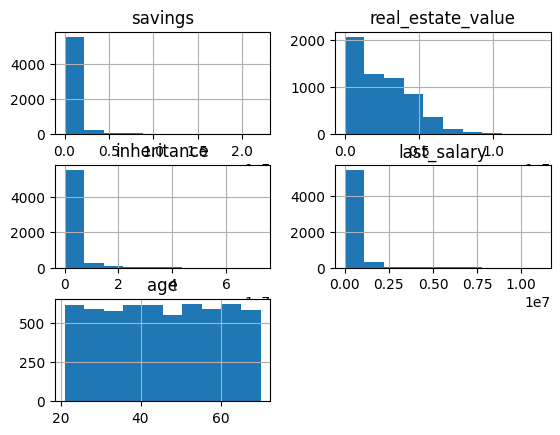

In [17]:
df.hist()

### Model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [19]:
categorical_cols = [
    "risk_profile", "investment_horizon", "investment_experience",
    "type_of_mandate", "passport_country", "marital_status"
]
numeric_cols = [
    "savings", "real_estate_value", "inheritance",
    "last_salary", "age"
]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# 3. Full pipeline with Random Forest
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['savings',
                                                   'real_estate_value',
                                                   'inheritance', 'last_salary',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['risk_profile',
                                                   'investment_horizon',
                                                   'investment_experience',
                                                   'type_of_mandate',
                                                   'passport_country',
                                                   'marital_status'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [20]:
y_pred = model.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Reject", "Accept"]))

📊 Classification Report:

              precision    recall  f1-score   support

      Reject       0.76      0.09      0.17       234
      Accept       0.82      0.99      0.90       963

    accuracy                           0.82      1197
   macro avg       0.79      0.54      0.53      1197
weighted avg       0.81      0.82      0.75      1197



### Evaluation

In [21]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

#def combined_model(X):
#    y = my_classifier.predict(all_data) 
# 

predictions = model.predict(df)

combined_predictions = [1]*len(all_data)
for i in range(len(all_data)):
    if (all_predictions[i] == 0):
        combined_predictions[i] = 0
for j, prediction in zip(indices_accepted, predictions):
    combined_predictions[j] = prediction


In [24]:
print("📊 Classification Report:\n")
print(classification_report(all_labels, combined_predictions, target_names=["Reject", "Accept"]))

📊 Classification Report:

              precision    recall  f1-score   support

      Reject       0.97      0.96      0.96      4992
      Accept       0.96      0.97      0.96      5008

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

